# Preference learning

#### Autorzy: Filip Marciniak 148148, Szymon Pasternak 148146

# Zbiór danych

Jako zbiór danych wybraliśmy `mammographic`.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from xgboost import plot_tree

In [2]:
df = pd.read_csv(
    'data/mammographic.csv',
    header=None,
    names=['one', 'two', 'three', 'four', 'five', 'class']
)
X, y = df.drop(columns=['class']), df['class']

In [3]:
X.describe()

,one,two,three,four,five
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,0.079890,0.484384,0.593976,0.453313,0.638554
std,0.034334,0.188100,0.414120,0.391794,0.116979
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072727,0.358974,0.333333,0.000000,0.666667
50%,0.072727,0.500000,0.666667,0.500000,0.666667
75%,0.090909,0.615385,1.000000,0.750000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
y.value_counts()

class
0.0    427
1.0    403
Name: count, dtype: int64

Zbiór danych posiada 5 kryteriów i klasę decyzyjną. W zbiorze zawartych jest 830 przykładów. Nie ma danych brakujących, czyli NULL. Każda z cech zawiera liczby rzeczywiste od 0 do 1. Klasa decyzyjna oznaczona jest jako 0 lub 1. Dane są zbalansowane, zawartych jest mniej więcej tyle samo przypadków z każdej klasy.

# Prosty interpretowalny model - XGBoost

## Trenowanie modelu

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = xgb.XGBClassifier(max_depth=3, n_estimators=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred)
f1_train = f1_score(y_train, y_pred)
auc_train = roc_auc_score(y_train, y_pred)

y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print(f"TRAIN: Accuracy: {accuracy_train:.2%}, F1: {f1_train:.2%}, AUC: {auc_train:.2%}")
print(f"TEST: Accuracy: {accuracy_test:.2%}, F1: {f1_test:.2%}, AUC: {auc_test:.2%}")

TRAIN: Accuracy: 84.74%, F1: 83.43%, AUC: 84.69%
TEST: Accuracy: 84.34%, F1: 79.37%, AUC: 83.18%


## Wizualizacja modelu

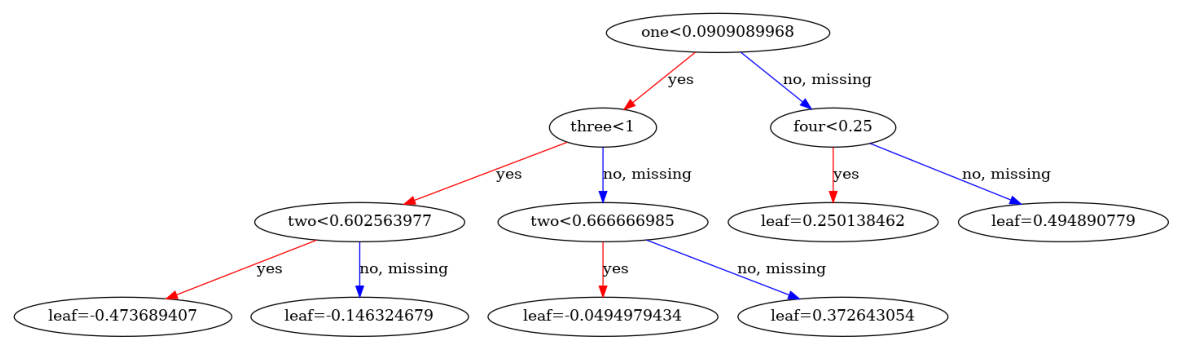

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0, fontsize=20);

## Interpretacja wizualizacji

Dzięki zaprezentowanej wizualizacji widzimy w jaki sposób wygląda zbudowane drzewo decyzyjne. Interpretacja takiego drzewa jest stosunkowo prosta - w celu klasyfikacji danego przykładu danych zaczynamy od korzenia i odpowiadamy na kolejne pytania, które zadawane są w poszczególnych węzłach. W liściach drzewa znajdują się wartości które podstawiamy do wzoru [1]

$$ \sigma(x) = \frac{1}{1 + e^{leaf}} $$

i w ten sposób obliczamy odpowiednie prawdopodobieństwo, na podstawie którego przypisujemy dany przypadek do klasy. \
W drzewie wyróżnić można dwa główne poddrzewa - prawe oraz lewe które zaczynają się od korzenia. W prawym korzeniu wszystkie przypadki trafiają do klasy 1, a w lewym znajduje się jedynie jeden liść, który zaklasyfikuje przypadki jako 1, a reszta jako 0 (przyjmując threshold dla sigmoidy jako x=0).

## Wyjaśnienie wybranych decyzji

### Wyjaśnienie decyzji dla 3 wybranych wariantów

Pobranie 3 losowych próbek ze zbioru danych:

In [7]:
df_sample = df.sample(3, random_state=21)
X_sample, y_sample = df_sample.drop(columns=['class']), df_sample['class']

Wykonanie predykcji na pobranych próbkach

In [8]:
y_pred = model.predict(X_sample)
X_sample['pred'] = y_pred
X_sample['true'] = y_sample
X_sample

,one,two,three,four,five,pred,true
452,0.072727,0.743590,1.000000,0.75,0.666667,1,0.0
601,0.072727,0.512821,0.333333,0.00,0.333333,0,0.0
678,0.090909,0.166667,1.000000,0.75,0.333333,1,1.0


**Wariant 452.** \
Został przypisany do klasy 1, ponieważ na atrybucie "one" posiada wartość mniejszą niż 0.09 i trafił do lewego poddrzewa. Następnie na pytanie three<1 odpowiedź brzmiała "no", a na pytaniu two<0.66 odpowiedź również brzmiała no. W taki sposób trafił do liście z wartością leaf=0.373, co sprawiło, że została przypisana mu klasa 1.

**Wariant 601.** \
Został przypisany do klasy 0, ponieważ na atrybucie "one" posiada wartość mniejszą niż 0.09 i trafił do lewej poddrzewa. Następnie w przeciwieństwie do poprzedniego wariantu na pytaniu three<1 odpowiedź brzmiała "yes", ponieważ posiada na nim wartość 0.33. W ten sposób trafił do liścia z ujemną wartością, co sprawiło, że została przypisana mu klasa 0.

**Wariant 678.** \
Został przypisany do klasy 1, ponieważ na atrybucie "one" posiada wartość większą niż 0.09 i trafił do prawego poddrzewa, w którym wszystkie liście (bez znaczenia na następne pytanie) przypisują klasę 1.

### Minimalna zmiana w ocenach 3 wariantów

#### Metoda analityczna

Dokonanie zmian w analizowanych przykładach

In [9]:
X_change = X_sample.copy()
X_change.loc[452, "three"] = 0.999
X_change.loc[601, "one"] = 0.091
X_change.loc[678, "one"] = 0.09

Wykonanie predykcji na wybranych przykładach

In [10]:
y_pred = model.predict(X_change[['one', 'two', 'three', 'four', 'five']])
X_change['pred_new'] = y_pred
X_change['true'] = y_sample
X_change

,one,two,three,four,five,pred,true,pred_new
452,0.072727,0.743590,0.999000,0.75,0.666667,1,0.0,0
601,0.091000,0.512821,0.333333,0.00,0.333333,0,0.0,1
678,0.090000,0.166667,1.000000,0.75,0.333333,1,1.0,0


Po dokonaniu zmian w wartościach można zaobserwować, że dla każdego z przykładów zostały przypisane inne klasy niż poprzednio. Nowe predykcje widoczne są w kolumnie `pred_new`, a oryginalne w `pred`. W kolumnie `true` umieszczone zostały prawdziwe klasy. 

Opis dokonanych zmian:

**Wariant 452** \
Ten wariant miał przypisaną klasę 1, więc należało zmienić ją na 0. Można to uzyskać poprzez zmniejszenie o niewielką wartość atrybutu "three" - ustawić na wartość mniejszą od 1. Wówczas przypadek trafia do najbardziej lewego poddrzewa i przypisywana jest mu klasa 0.

**Wariant 601** \
Ten wariant miał przypisaną klasę 0, więc należało zmienić ją na 1. Wystarczyło zmienić o niewielką wartość (około 0.02) wartość na atrybucie "one", aby w pierwszym pytaniu zamiast na lewą stronę, przypadek znalazł się po prawej stronie drzewa i została mu przypisana klasa 1.

**Wariant 678** \
Ten wariant miał przypisaną klasę 1, więć należało zmienić ją na 0. Można to było uzyskać ponownie poprzez niewielką zmianę na atrybucie "one" - zmiana z 0.0909 na 0.09. Pozostałe atrybuty mogły pozostać niezmienione.

#### Próbkowanie przestrzeni

In [11]:
STEP = 0.01
variants = X_sample.index.to_list()
best_solution = None

for variant in variants:
    min_distance = 1
    best_solution = None
    for attribute in X.columns:
        X_new = pd.DataFrame(X.loc[variant, :]).T
        for value in np.arange(0, 1, 0.001):
            X_new.loc[variant, attribute] = value
            y_pred = model.predict(X_new)
            
            new_distance = mean_absolute_error(
                X.loc[variant, :],
                X_new.loc[variant, :]
            )
            if y_pred[0] != X_change.loc[variant, "pred"] and new_distance < min_distance:
                min_distance = new_distance
                best_solution = X_new.copy()
    print(best_solution)

          one      two  three  four      five
452  0.072727  0.74359  0.999  0.75  0.666667
       one       two     three  four      five
601  0.091  0.512821  0.333333   0.0  0.333333
      one       two  three  four      five
678  0.09  0.166667    1.0  0.75  0.333333


Próbkowanie przetrzeni przyniosło podobne rezultaty i obserwacje do tych, które zostały osiągnięte metodą analityczną. Dla wariantu 452 należy zmniejszyć nieco wartość na atrybucie "three", dla wariantu 601 podnieść wartość na atrybucie "one", a dla wariantu 678 obniżyć wartość na atrybucie "one".

### Wyjaśnienie decyzji za pomocą wyspecjalizowanej techniki

Jako technikę zdecydowaliśmy się wybrać bibliotekę `shap` ze względu na dużą liczbę dostępnych przykładów w dokumentacji oraz przejrzystość w oferowanych przez bibliotekę metodach.

In [12]:
import shap

In [13]:
explainer = shap.Explainer(model)
df_sample = df.sample(3, random_state=21)
X_sample = df_sample.drop(columns=['class'])
shap_values = explainer(X_sample)

**Wariant 452**

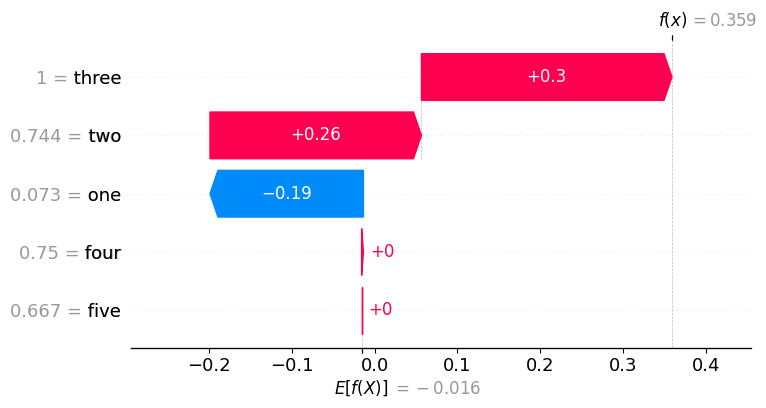

In [14]:
shap.plots.waterfall(shap_values[0])

Na wizualizacji widać potwierdzenie wcześniejszego omówienie - na podstawie wartości na atrybutach two i three wariant uzyskuje klasę 1.

**Wariant 601**

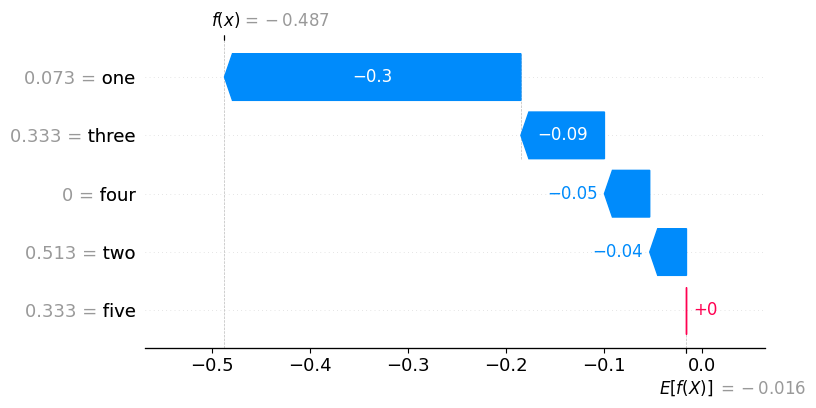

In [15]:
shap.plots.waterfall(shap_values[1])

Wszystkie wartości na atrybutach one, three i two, wskazują, że wariant uzyskuje klasę 0.

**Wariant 678**

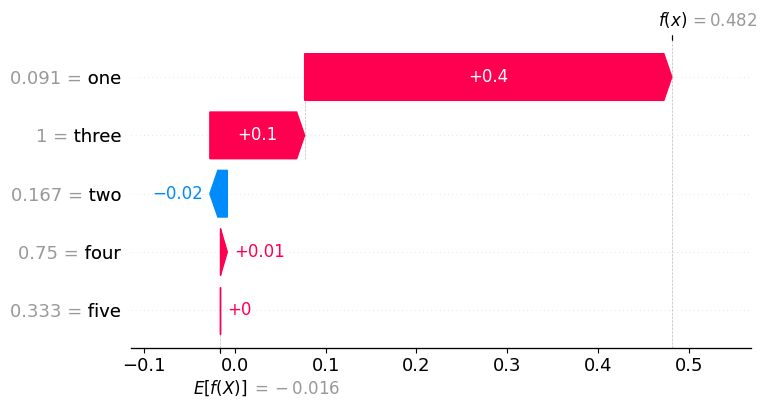

In [16]:
shap.plots.waterfall(shap_values[2])

Podobnie jak w poprzednich omawianych przykładach, największe znaczenie ma atrybut one, dla którego uzyskana wartość większa równa 0.0909 powoduje, że wariant uzyskuje klasę 1.

## Interpretacja modelu

### Preferencje użytkowników

Użytkownicy preferują warianty, które uzyskują wartość powyżej 0.09 na kryterium "one". Im lepsze oceny wariantu, tym większa szansa, że otrzyma on klasę 1.

### Wpływ każdego z kryteriów

Największy wpływ ma kryterium "one". Znajduje się ono w korzeniu drzewa i tak naprawdę decyduje czy dany wariant ma szansę na uzyskanie klasy 0. Następnie można ex-aequo wyróżnić atrybuty "two" i "three", ponieważ one również decydują czy dany przypadek osiągnie klasę 0 czy 1. Na wybór nie ma wpływu atrybut "four", który mimo tego że używany jest w prawym poddrzewie, zawsze prowadzi do wartości, które wskazują klasę 1. Atrybut "five" nie ma żadnego znaczenia, ponieważ nie znajduje się nawet w drzewie.

### Charakter kryteriów

Na podstawie wizualizacji drzewa można wywnioskować, że wszystkie z kryteriów które mają znaczenie (one, two, three, four) w obliczaniu prawdopodobieństwa zwracanego przez drzewo mają charakter zysk, ponieważ jeżeli wariant uzyskuje lepsze oceny to wartość leaf, która następnie jest wykorzystywana w sigmoidzie zwiększa się. Sprawia to, że warianty z niskimi ocenami trafiają do klasy 0, a z wysokimi 1. 

### Wykorzystanie Permutation Feature Importance

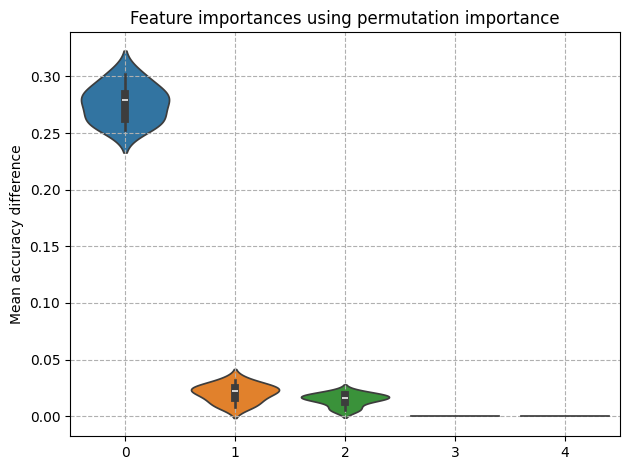

In [16]:
import seaborn as sns
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(result.importances.T), ax=ax)
plt.grid(linestyle='--')
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
fig.tight_layout()
plt.show();

Na podstawie powyższego wykresu widać to co ustalone zostało również we wcześniejszych obserwacjach i wnioskach. Najważniejsze są trzy pierwsze kryteria, czyli atrybuty one, two i three. Atrybuty four i five nie mają znaczenia dla działania algorytmu.

# Interpretowalny model - ANN-Ch-Constr.

## Trenowanie modelu

In [17]:
# Stała definiująca checkpoint modelu
# Aby zmienić model na podstawie którego napisano wnioski należy zmienić wartość na 'models/choquet.pt'
PATH = 'models/choquet_test.pt'

In [18]:
from utils import *
from ann_model import LinearGreaterThanZero, LinearInteraction, ChoquetIntegralConstrained, mobious_transform

# Wczytanie danych
path = 'data/mammographic.csv'
data = pd.read_csv(path, header=None)
num_criteria = 5

data_input = data.iloc[:, :num_criteria].apply(lambda x: mobious_transform(x), axis=1, result_type ='expand')
data_target = data[num_criteria]

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values,
    data_target.values,
    test_size=0.2,
    random_state=42
)

In [19]:
# Utworzenie DataLoaders
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [20]:
model = ChoquetIntegralConstrained(num_criteria)
best_acc, best_auc, stats_train, stats_test = Train(model, train_dataloader, test_dataloader, PATH, lr=0.01, epoch_nr=100)

100%|██████████| 100/100 [00:01<00:00, 65.92it/s]


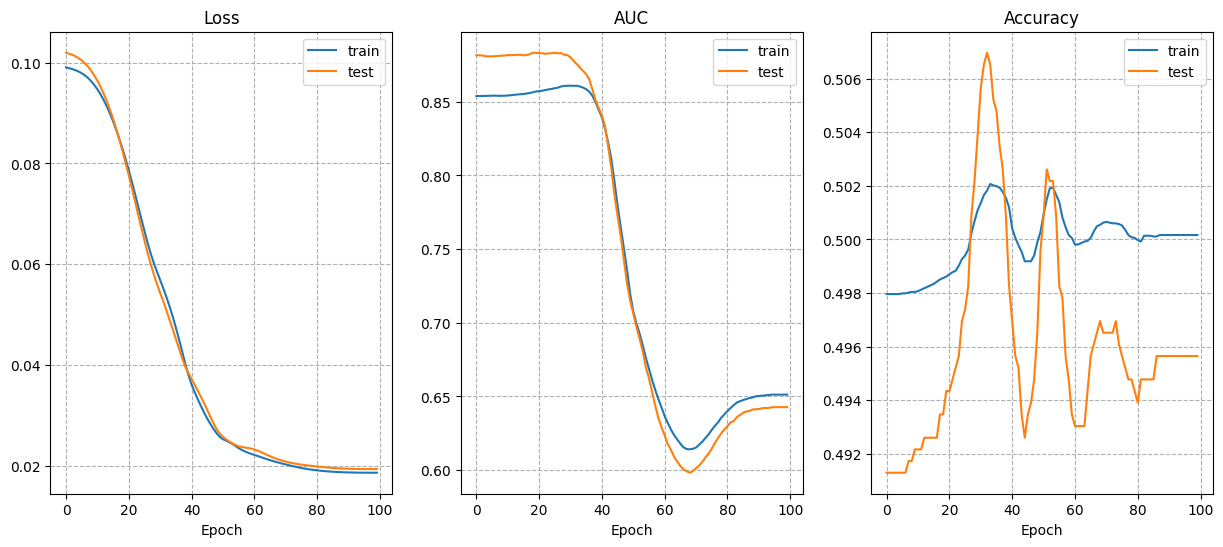

In [21]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses, label='train')
ax.plot(stats_test.losses, label='test')
ax.set_title('Loss')
ax.grid(linestyle='--')
ax.set_xlabel('Epoch')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores, label='train')
ax.plot(stats_test.auc_scores, label='test')
ax.set_title('AUC')
ax.grid(linestyle='--')
ax.set_xlabel('Epoch')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores, label='train')
ax.plot(stats_test.acc_scores, label='test')
ax.set_title('Accuracy')
ax.grid(linestyle='--')
ax.set_xlabel('Epoch')
ax.legend()

plt.show();

In [22]:
MODEL_PATH = 'models/choquet.pt'
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum()+interaction_weights.sum()
weights = weights/s
interaction_weights = interaction_weights/s

interactions = np.zeros((num_criteria,num_criteria))
weight_id =0
for i in range(num_criteria):
    for j in range(i+1,num_criteria):
        
        interactions[i,j] = interactions[j,i] = interaction_weights[weight_id]
        weight_id+=1

In [24]:
print('Criteria weights:')
print(weights)
print()
print('Criteria interactions:')
print(interactions)

Criteria weights:
[0.33148026 0.09784395 0.13513255 0.04225278 0.32884276]

Criteria interactions:
[[ 0.          0.08209426 -0.01607624  0.10338027  0.01245008]
 [ 0.08209426  0.         -0.03763013 -0.0098792   0.07125492]
 [-0.01607624 -0.03763013  0.         -0.04225278 -0.05664073]
 [ 0.10338027 -0.0098792  -0.04225278  0.         -0.04225278]
 [ 0.01245008  0.07125492 -0.05664073 -0.04225278  0.        ]]


## Wizualizacja otrzymanych wag - heatmapa

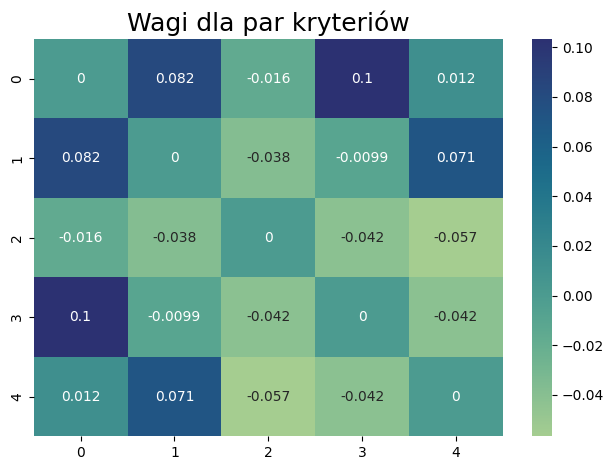

In [25]:
sns.heatmap(interactions, annot=True, cmap="crest")
plt.title("Wagi dla par kryteriów", fontsize=18)
plt.tight_layout()
plt.show();

## Wyjaśnienie wybranych decyzji

### Wyjaśnienie decyzji dla 3 wybranych wariantów

Pobranie 3 próbek ze zbioru danych:

In [26]:
df_sample = df.sample(3, random_state=21)
X_sample, y_sample = df_sample.drop(columns=['class']), df_sample['class']
X_sample_t = X_sample.apply(lambda x: mobious_transform(x), axis=1, result_type ='expand')
X_sample_t

/app/PREFERENCE-LEARNING/ann_model.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return  list(row) + [min(row[i],row[j]) for i in range(len(row)) for j in range(i+1,len(row))]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
452,0.072727,0.743590,1.000000,0.75,0.666667,0.072727,0.072727,0.072727,0.072727,0.743590,0.743590,0.666667,0.75,0.666667,0.666667
601,0.072727,0.512821,0.333333,0.00,0.333333,0.072727,0.072727,0.000000,0.072727,0.333333,0.000000,0.333333,0.00,0.333333,0.000000
678,0.090909,0.166667,1.000000,0.75,0.333333,0.090909,0.090909,0.090909,0.090909,0.166667,0.166667,0.166667,0.75,0.333333,0.333333


Wykonanie predykcji na wybranych próbkach

In [27]:
with torch.no_grad():
    y_pred = model(torch.Tensor(X_sample_t.values))

print(y_pred)
print(model.threshold_layer.threshold)

tensor([[ 0.0235],
        [-0.1602],
        [-0.1085]])
Parameter containing:
tensor([0.3872], requires_grad=True)


**Wariant 452** \
Został przypisany do klasy 1, ponieważ na podstawie nauczonych wag oraz progów, które wykorzystywane są w procedurze sortowania uzyskał wartość większą od 0. Oznacza to, że $ Sc(a_i) - t > 0 $. Uzyskana wartość wynika z obliczenia odpowiedniej Całki Choquet:
`(0.072727*0.33148026 + 0.743590*0.09784395 + 1.000000*0.13513255 + 0.75*0.04225278 + 0.666667*0.32884276 + 0.072727*0.08209426 + 0.072727*-0.01607624 + 0.072727*0.10338027 + 0.072727*0.01245008 + 0.743590*-0.03763013 + 0.743590*-0.0098792 + 0.666667*0.07125492 + 0.75*-0.04225278 + 0.666667*-0.05664073 + 0.666667*-0.04225278)` oraz odjęcie od niej wartości threshold `0.3872`.

**Wariant 601** \
Został przypisany do klasy 0, ponieważ na podstawie nauczonych wag oraz progów, które wykorzystywane są w procedurze sortowania uzyskał wartość mniejszą od 0.

**Wariant 678** \
Został przypisany do klasy 0, ponieważ na podstawie nauczonych wag oraz progów, które wykorzystywane są w procedurze sortowania uzyskał wartość mniejszą od 0.

### Minimalna zmiana w ocenach 3 wariantów

#### Metoda analityczna

Chcemy zmieniać wartości na kryteriach które mają sporą wagę (1, 3, 5), ale jednocześnie nie ruszać wartości wynikających z transformaty Mobiusa, aby zmiany były jak najmniejsze.

**Wariant 452** \
Zmiana kryterium trzeciego z 1.0 na 0.82 ustawia ten wariant minimalnie pod progiem t, co sprawiłoby, że zostałby przydzielony do innej klasy.
`(0.072727*0.33148026 + 0.743590*0.09784395 + 0.82*0.13513255 + 0.75*0.04225278 + 0.666667*0.32884276 + 0.072727*0.08209426 + 0.072727*-0.01607624 + 0.072727*0.10338027 + 0.072727*0.01245008 + 0.743590*-0.03763013 + 0.743590*-0.0098792 + 0.666667*0.07125492 + 0.75*-0.04225278 + 0.666667*-0.05664073 + 0.666667*-0.04225278) = 0.3863`

**Wariant 601** \
Zmiana kryterium piątego z 0.33 na 0.82 powoduje, że wariant znajduje się mininalnie nad progiem t. 
`(0.072727*0.33148026 + 0.512821*0.09784395 + 0.333333*0.13513255 + 0.00*0.04225278 + 0.89*0.32884276 + 0.072727*0.08209426 + 0.072727*-0.01607624 + 0.00000*0.10338027 + 0.072727*0.01245008 + 0.89*-0.03763013 + 0.000000*-0.0098792 + 0.333333*0.07125492 + 0.00*-0.04225278 + 0.333333*-0.05664073 + 0.000000*-0.04225278) = 0.3890`

**Wariant 678** \
Zmiana kryterium piątego z 0.33 na 0.8 powoduje, że wariant znajduje się minimalnie nad progiem t.
`(0.090909*0.33148026 + 0.166667*0.09784395 + 1.000000*0.13513255 + 0.75*0.04225278 + 0.8*0.32884276 + 0.090909*0.08209426 + 0.090909*-0.01607624 + 0.090909*0.10338027 + 0.090909*0.01245008 + 0.166667*-0.03763013 + 0.166667*-0.0098792 + 0.166667*0.07125492 + 0.75*-0.04225278 + 0.8*-0.05664073 + 0.75*-0.04225278) = 0.3881`

Możliwe, że mniejsze zmiany są uzyskiwalne, ponieważ interpretacja nie jest tak łatwa jak w przypadku prostego modelu interpretowalnego. Zostanie sprawdzone to metodą próbkowania przestrzeni.

#### Próbkowanie przestrzeni

In [28]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    STEP = 0.01
    variants = X_sample.index.to_list()
    best_solution = None
    
    for i, variant in enumerate(variants):
        min_distance = 1
        best_solution = None
        for attribute in X.columns:
            X_new = pd.DataFrame(X.loc[variant, :]).T
            for value in np.arange(0, 1, 0.001):
                X_new.loc[variant, attribute] = value
    
                X_new_t =  X_new.apply(lambda x: mobious_transform(x), axis=1, result_type ='expand')
                with torch.no_grad():
                    y_pred_new = model(torch.Tensor(X_new_t.values))
                    
                new_distance = mean_absolute_error(
                    X.loc[variant, :],
                    X_new.loc[variant, :]
                )
                if (
                    (y_pred[i][0] > 0 and y_pred_new[0][0] < 0) or (y_pred[i][0] < 0 and y_pred_new[0][0] > 0)
                ) and new_distance < min_distance:
                    min_distance = new_distance
                    best_solution = X_new.copy()
        print(best_solution)

       one      two  three  four      five
452  0.026  0.74359    1.0  0.75  0.666667
       one       two     three  four      five
601  0.463  0.512821  0.333333   0.0  0.333333
       one       two  three  four      five
678  0.328  0.166667    1.0  0.75  0.333333


Próbkowanie przestrzeni przyniosło odmienne rezultaty i w każdym przypadku dokonało zmiany na kryterium numer 1. Ma to jak najbardziej uzasadnienie, ponieważ to kryterium ma dużą wagę - 0.33.

### Wyjaśnienie decyzji za pomocą wyspecjalizowanej techniki

  0%|          | 0/3 [00:00<?, ?it/s]

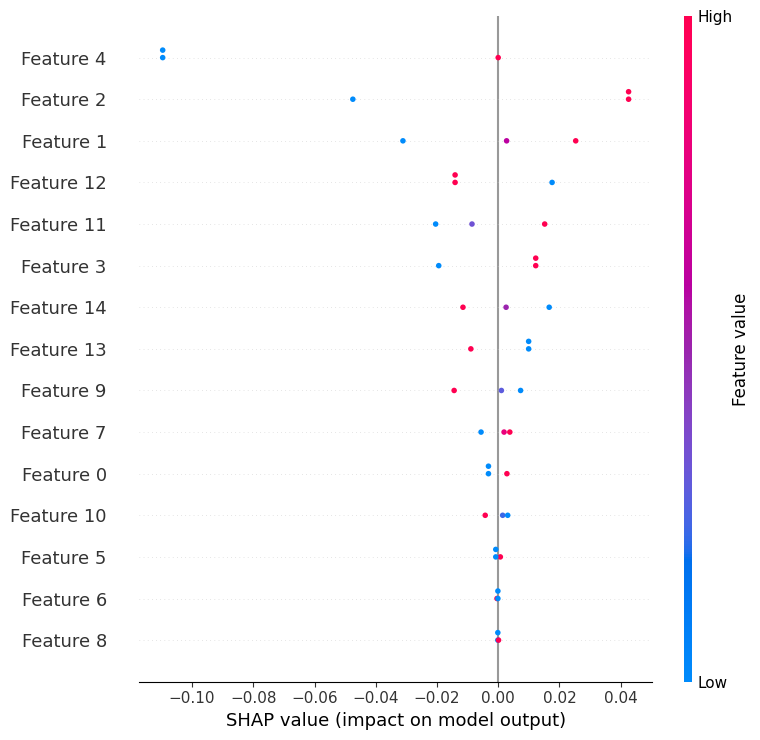

In [29]:
# Wrapper function to get predictions
def model_predict_mobius(x):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.Tensor(x))
    return y_pred.numpy().flatten()

X_sample_numpy = X_sample_t.to_numpy()

explainer = shap.KernelExplainer(model_predict_mobius, shap.kmeans(X_train, 3))
shap_values = explainer.shap_values(X_sample_numpy)
shap.summary_plot(shap_values, X_sample_numpy)

Na podstawie wykresu możemy zaobserwować, że największy impact mają wartości na kryterium 5 (feature 4, poniewaz liczone są od 0). Kryteria uzyskane poprzez transformatę morbiusa również mają znaczenie.

## Interpretacja modelu

### Preferencje użytkowników

Użytkownicy najbardziej cenią kryteria 1, 3, 5, ponieważ mają one największe wagi. Wśród interakcji pomiędzy kryteriami można wyróżnić parę {1, 4} - waga aż 0.1. Pojawiają się również minusowe wagi (na przykład pomiędzy kryterium 3 i 5, które świadczą o tym, że występuje ujemna synergia jeżeli wariant jest dobry na tych dwóch kryteriach dobry równocześnie. Jednak wagi, które dotyczą par mają dość małe wartości w przeciwieństwie do tych, które dotyczą kryteriów pojedynczo.

### Wpływ każdego z kryteriów

Największy wpływ na wynik i przypisanie do klasy mają kryteria 1, 3 oraz 5, ponieważ posiadają odpowiednio wagi 0.33, 0.13 i 0.32. Pozostałe dwa kryteria nie mają takiego znaczenia - kryterium 2 ma wagę 0.09, a 4 wagę 0.04.

### Charakter kryteriów

Wszystkie kryteria mają charakter zysk, ponieważ wszystkie wagi są dodatnie. Im większe wartości na poszczególnych kryteriach, tym większa wartość $ Sc(a_i) $, a co za tym idzie większa szansa, że będzie to wartość większa od progu t, który definiuje przypisanie do klasy.

### Progi preferencji

W tej metodzie mamy próg preferencji, który dzieli cały zakres możliwych uzyskiwanych ocen na klasy, do których przypisywane są warianty.

### Obliczenie indeksu Shapleya

In [30]:
shapley = weights + interactions.sum(0)/2
print('Importance of criterina (Shapley value):')
print(shapley)

Importance of criterina (Shapley value):
[0.42240445 0.15076387 0.05883261 0.04675053 0.3212485 ]


Ważności kryteriów obliczone przy użyciu indeksu Shapleya potwierdzają, że najważniejsze są kryteria 1 oraz 5.

# Sieć neuronowa z nieliniową funkcją aktywacji

## Trenowanie modelu

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.block(x)
        return x

df = pd.read_csv(
    'data/mammographic.csv',
    header=None,
    names=['one', 'two', 'three', 'four', 'five', 'class']
)
X, y = df.drop(columns=['class']), df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


model = NeuralNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trenowanie sieci
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Ewaluacja sieci na zbiorze testowym
model.eval()
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).squeeze(1).float()
        all_labels.extend(y_batch.numpy())
        all_preds.extend(preds.numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)
print(accuracy, f1, roc_auc)

Epoch [5/50], Loss: 0.5897
Epoch [10/50], Loss: 0.6648
Epoch [15/50], Loss: 0.2783
Epoch [20/50], Loss: 0.4030
Epoch [25/50], Loss: 0.5625
Epoch [30/50], Loss: 0.2180
Epoch [35/50], Loss: 0.1359
Epoch [40/50], Loss: 0.6877
Epoch [45/50], Loss: 0.3231
Epoch [50/50], Loss: 0.5095
0.8192771084337349 0.810126582278481 0.8529411764705882


In [32]:
PATH = 'models/net_test.pt'
torch.save(model.state_dict(), PATH)

In [33]:
MODEL_PATH = 'models/net.pt'
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(model)

NeuralNet(
  (block): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Wyjaśnienie wybranych decyzji

Pobranie 3 próbek ze zbioru danych

In [34]:
df_sample = df.sample(3, random_state=21)
X_sample, y_sample = df_sample.drop(columns=['class']), df_sample['class']
X_sample

,one,two,three,four,five
452,0.072727,0.743590,1.000000,0.75,0.666667
601,0.072727,0.512821,0.333333,0.00,0.333333
678,0.090909,0.166667,1.000000,0.75,0.333333


Wykonanie predykcji na wybranych próbkach

In [35]:
X_sample_tensor = torch.tensor(X_sample.to_numpy(), dtype=torch.float32)
y_sample_tensor = torch.tensor(y_sample.values, dtype=torch.long)

with torch.no_grad():
    outputs = model(torch.Tensor(X_sample_tensor))
    probs = torch.sigmoid(outputs)
    y_pred_org = (probs > 0.5).float()

print(y_pred_org)
print(y_sample_tensor)

tensor([[1.],
        [0.],
        [1.]])
tensor([0, 0, 1])


Ponieważ wywnioskowanie i uzasadnienie wyniku w sposób analityczny jest skomplikowane w przypadku sieci z nieliniowymi funkcjami aktywacji, posłużymy się od razu pakietem `shap`.

### Wyjaśnienie decyzji za pomocą wyspecjalizowanej techniki

  0%|          | 0/3 [00:00<?, ?it/s]

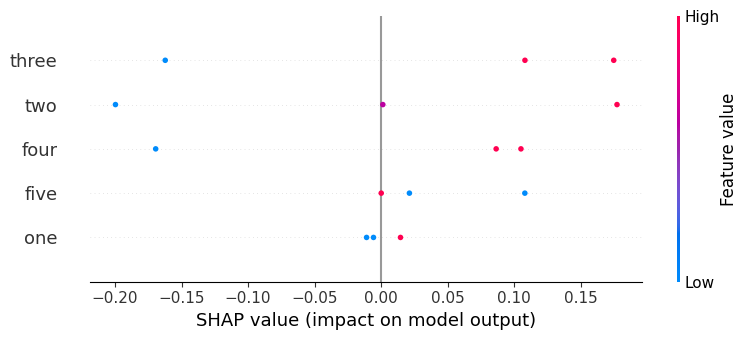

In [36]:
# Wrapper function that calculates probabilities
def model_predict(x):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(x, dtype=torch.float32))
        probs = torch.sigmoid(outputs).numpy().flatten()
    return probs

X_sample_numpy = X_sample_tensor.numpy()
X_train_numpy = X_train_tensor.numpy()

explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_train_numpy, 10))
shap_values = explainer.shap_values(X_sample_numpy)
shap.summary_plot(shap_values, X_sample_numpy, feature_names=['one', 'two', 'three', 'four', 'five'])

Na podstawie wygenerowanego wykresu widzimy, że największy wpływ na wyjście modelu mają wartości najmniejsze i największe (oznaczone odpowiednio niebieskim i czerwonym kolorem) na atrybutach three, two i four.

Poniżej zamieszczone są obliczenia dla poszczególnych wariantów:

**Wariant 452**

  0%|          | 0/1 [00:00<?, ?it/s]

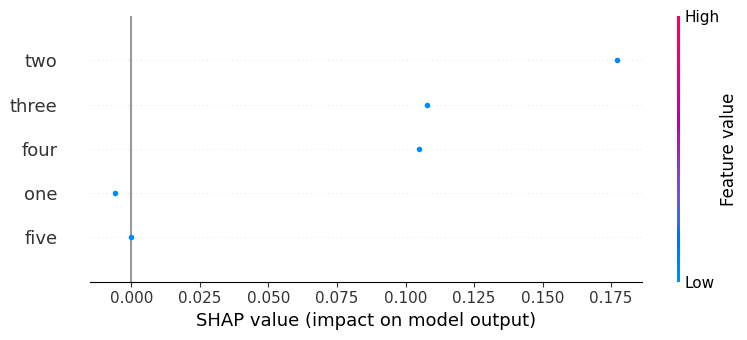

In [37]:
explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_train_numpy, 10))
shap_values = explainer.shap_values(np.expand_dims(X_sample_numpy[0], axis=0))
shap.summary_plot(shap_values, np.expand_dims(X_sample_numpy[0], axis=0), feature_names=['one', 'two', 'three', 'four', 'five'])

Impact jest bardziej na prawo - klasa 1.

**Wariant 601**

  0%|          | 0/1 [00:00<?, ?it/s]

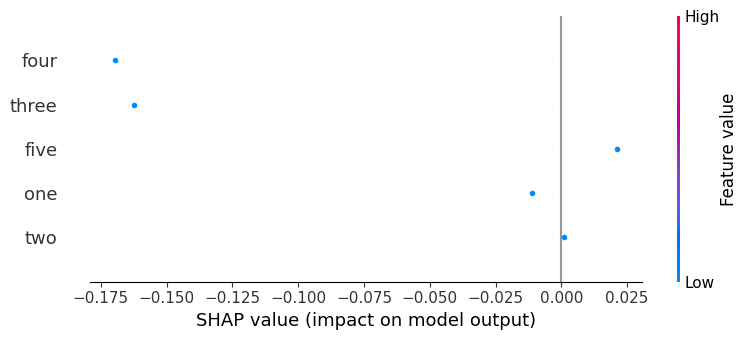

In [38]:
explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_train_numpy, 10))
shap_values = explainer.shap_values(np.expand_dims(X_sample_numpy[1], axis=0))
shap.summary_plot(shap_values, np.expand_dims(X_sample_numpy[1], axis=0), feature_names=['one', 'two', 'three', 'four', 'five'])

Impact jest bardziej na minusie, więc klasa 0.

**Wariant 678**

  0%|          | 0/1 [00:00<?, ?it/s]

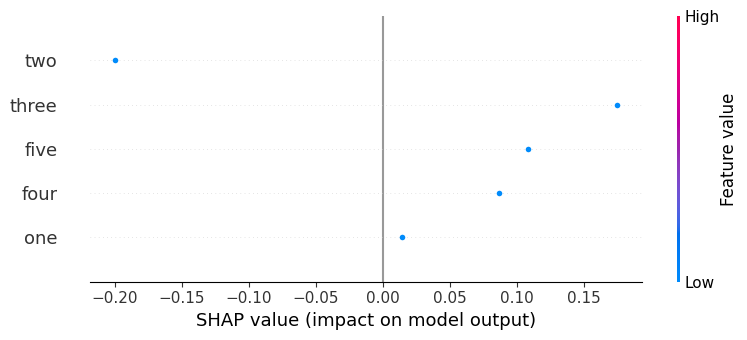

In [39]:
explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_train_numpy, 10))
shap_values = explainer.shap_values(np.expand_dims(X_sample_numpy[2], axis=0))
shap.summary_plot(shap_values, np.expand_dims(X_sample_numpy[2], axis=0), feature_names=['one', 'two', 'three', 'four', 'five'])

Impact jest bardziej na prawo, więc klasa 1.

### Minimalna zmiana w ocenach 3 wariantów

#### Próbkowanie przestrzeni

In [ ]:
STEP = 0.01
variants = X_sample.index.to_list()
best_solution = None

for i, variant in enumerate(variants):
    min_distance = 1
    best_solution = None
    for attribute in X.columns:
        X_new = pd.DataFrame(X.loc[variant, :]).T
        for value in np.arange(0, 1, 0.001):
            X_new.loc[variant, attribute] = value

            with torch.no_grad():
                outputs = model(torch.Tensor(X_new.values))
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).squeeze(1).float()
                
            new_distance = mean_absolute_error(
                X.loc[variant, :],
                X_new.loc[variant, :]
            )
            if preds[0] != y_pred_org[i][0] and new_distance < min_distance:
                min_distance = new_distance
                best_solution = X_new.copy()
    print(best_solution)

          one    two  three  four      five
452  0.072727  0.232    1.0  0.75  0.666667


Dla wariantu 452 zmieniony został atrybut two z 0.744 na 0.232 (czyli zmiejszenie - zmiana wartości na mniejszą spowodowała zmianę klasy z 1 na 0). \
Dla wariantu 601 zmieniony został atrybut one z 0.073 na 0.308 (czyli zwiększenie - zmiana wartości na większą spowodowała zmianę klasy z 0 na 1). \
Dla wariantu 678 zmieniony został atrybut one z 0.09 na 0.004 (czyli zmniejszenie - zmiana wartości na mniejsza spodowodowała zmianę klasy z 1 na 0).

## Interpretacja modelu

### Preferencje użytkowników

Użytkownicy preferują warianty, które uzyskują wysokie oceny na wszystkich kryteriach. Na podstawie wariantu 601 można powiedzieć, że niskie oceny na kryteriach trzy i cztery spodowały, że znalazł się on w klasie 0.

### Wpływ każdego z kryteriów

Najważniejsze są kryteria trzy i dwa, na których oceny mają duży wpływ na wynik modelu. Jednakże niskie (lub wysokie) oceny na innych kryteriach mogą zaważyć o wyniku (przykładowo dla wariantu 706 jest to kryterium cztery. 

### Charakter kryteriów

Wszystkie kryteria mają charakter zysk. Im większe oncey, tym wyższa klasa.

# Podsumowanie

W ramach zadania udało się zaimplementować oraz przetestować 3 różne modele - XGBoost, ANN-Ch-Constr oraz sieć neuronową złożoną z wielu neuronów oraz nieliniowych funkcji aktywacji. Dalsze kierunki rozwoju obejmują porównanie otrzymanych wyników między sobą czy też wykorzystanie innych modeli do modelowania preferencji użytkowników.

# Źródła

[1] https://stackoverflow.com/a/50940011/16191733